In [40]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import plotting

In [41]:
# force gpu use
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [42]:
def setup_model() -> tf.keras.models.Sequential:
    @tf.function
    def custom_activation(x):
        return tf.sin(x)

    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input((2,)),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=32, activation=custom_activation),
            tf.keras.layers.Dense(units=1),
        ]
    )

    model.summary()
    model.compile(optimizer="Adam", loss="mean_squared_error")
    return model, tf.keras.optimizers.Adam(learning_rate=0.001)

$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}=f$

In [43]:
tf_pi = tf.constant(np.pi)

# TODO: experiment with tf function and parameters
@tf.function
def f(x, y):
    return -2 * tf_pi * tf_pi * tf.sin(tf_pi * y) * tf.sin(tf_pi * x)

### Params

In [44]:
grid_size = (50, 50)
plotting_grid_size = (200, 200)
x_limits = (0, 2)
y_limits = (0, 2)
border_grid_size = (50, 50)

EPOCHS = 3000
EPRINT = 500
LOSS = 1e-1  #1e-4

def checkpoint_path(ind: int) -> str:
    return f"../models/model{ind}.weights.h5"

In [45]:
def get_area(grid_size, x_limits, y_limits):
    x = np.linspace(x_limits[0], x_limits[1], grid_size[0], dtype=np.float32)[1:-1]
    y = np.linspace(y_limits[0], y_limits[1], grid_size[1], dtype=np.float32)[1:-1]

    # FIXME: area inside points is in border??
    return mesh_to_pairs(np.meshgrid(x, y))


def get_border(border_grid_size, x_limits, y_limits):
    x = np.linspace(x_limits[0], x_limits[1],
                    border_grid_size[0], dtype=np.float32)
    y = np.linspace(y_limits[0], y_limits[1],
                    border_grid_size[1], dtype=np.float32)
    x_first = np.full(border_grid_size[0], x[0])
    x_last = np.full(border_grid_size[0], x[-1])
    y_first = np.full(border_grid_size[1], y[0])
    y_last = np.full(border_grid_size[1], y[-1])
    border = np.concatenate((np.column_stack((x_first, x)), np.column_stack(
        (x_last, x)), np.column_stack((y, y_first))[1:-1], np.column_stack((y, y_last))[1:-1]))
    return border


def mesh_to_pairs(meshgrid: list[np.ndarray]):
    return np.column_stack((meshgrid[0].flatten(), meshgrid[1].flatten()))

In [46]:
@tf.function
def ode_system(net, koef, coord, border):
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
        tape.watch(coord)
        with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape1:
            tape1.watch(coord)
            u = net(coord)
        grad_u = tape1.gradient(u, coord)
        du_dx = grad_u[..., 0]
        du_dy = grad_u[..., 1]
        del tape1

    d2u_dx2 = tape.gradient(du_dx, coord)[..., 0]
    d2u_dy2 = tape.gradient(du_dy, coord)[..., 1]
    del tape
    
    x = coord[..., 0]
    y = coord[..., 1]
    ode_loss = d2u_dx2 + d2u_dy2 - f(x, y)
    IC_loss = net(border) - tf.zeros((len(border), 1))

    return tf.reduce_mean(tf.square(ode_loss)) + koef * tf.reduce_mean(tf.square(IC_loss))

In [47]:
# train model
@tf.function
def train_with_loss(net, optm, koef, train_coord, border):
    for itr in tf.range(0, EPOCHS):
        with tf.GradientTape() as tape:
            train_loss = ode_system(net, koef, train_coord, border)
            # TODO: tf.summary
            # train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, net.trainable_variables)
        optm.apply_gradients(zip(grad_w, net.trainable_variables))
        del tape

        if itr % EPRINT == 0:
            # USE TF.PRINT()!!!
            tf.print("epoch:", itr, "loss:", train_loss)  #.numpy())
            if train_loss < LOSS:
                break

In [48]:
model, optm = setup_model()
initial_weights = model.get_weights()

for i in range(3):
    model.set_weights(initial_weights)
    koef = i
    
    # if os.path.isfile(checkpoint_path(i)):
    #     model.load_weights(checkpoint_path(i))
    # else:
    #     os.mknod(checkpoint_path(i))

    train_with_loss(model, optm, koef, *get_area(grid_size, border_grid_size, x_limits, y_limits))
    print("Training ended successfully\n")

    model.save_weights(checkpoint_path(i))
    # plotting.NNPlots.plotLoss(train_loss_record)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

epoch: 0 loss: 114.916565
epoch: 500 loss: 0.708956301
epoch: 1000 loss: 0.165456593
epoch: 1500 loss: 0.0629274249
Training ended successfully

epoch: 0 loss: 114.99231
epoch: 500 loss: 0.162953854
epoch: 1000 loss: 0.0604298487
Training ended successfully

epoch: 0 loss: 115.068054
epoch: 500 loss: 0.36394012
epoch: 1000 loss: 0.127494693
epoch: 1500 loss: 0.0544957221
Training ended successfully



In [49]:
def real_u(area):
    area = np.array(area)
    if len(area.shape) >= 3:
        x = area[0]
        y = area[1]
        return np.sin(np.pi * x) * np.sin(np.pi * y)
    else:
        return np.array([np.sin(np.pi * x) * np.sin(np.pi * y)  for x, y in area])

In [50]:
"""
Preparing usefull arrays for plotting and accuracy calculation
"""

# TODO: set area and border in different arrays
x = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[0])
y = np.linspace(y_limits[0], y_limits[1], plotting_grid_size[1])
x, y = np.meshgrid(x, y)
test_x = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[0])
test_y = np.linspace(x_limits[0], x_limits[1], plotting_grid_size[1])
test_x, test_y = np.meshgrid(test_x, test_y)
train_u = real_u((x, y))
true_u = real_u((test_x, test_y))
test_coord = np.column_stack((test_x.flatten(), test_y.flatten()))
pred_coord = list()
for _x in x[0]:
    for _y in x[0]:
        pred_coord.append([_x, _y])
pred_u = model.predict(np.array(pred_coord)).ravel().reshape(plotting_grid_size[0], plotting_grid_size[1])

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


/home/c0c0nut/Projects/PINN_Puasson/src/plotting.py:74: UserWarning: The following kwargs were not used by contour: 'linestyle'
  real.contour(
/home/c0c0nut/Projects/PINN_Puasson/src/plotting.py:95: UserWarning: The following kwargs were not used by contour: 'linestyle'
  pred.contour(


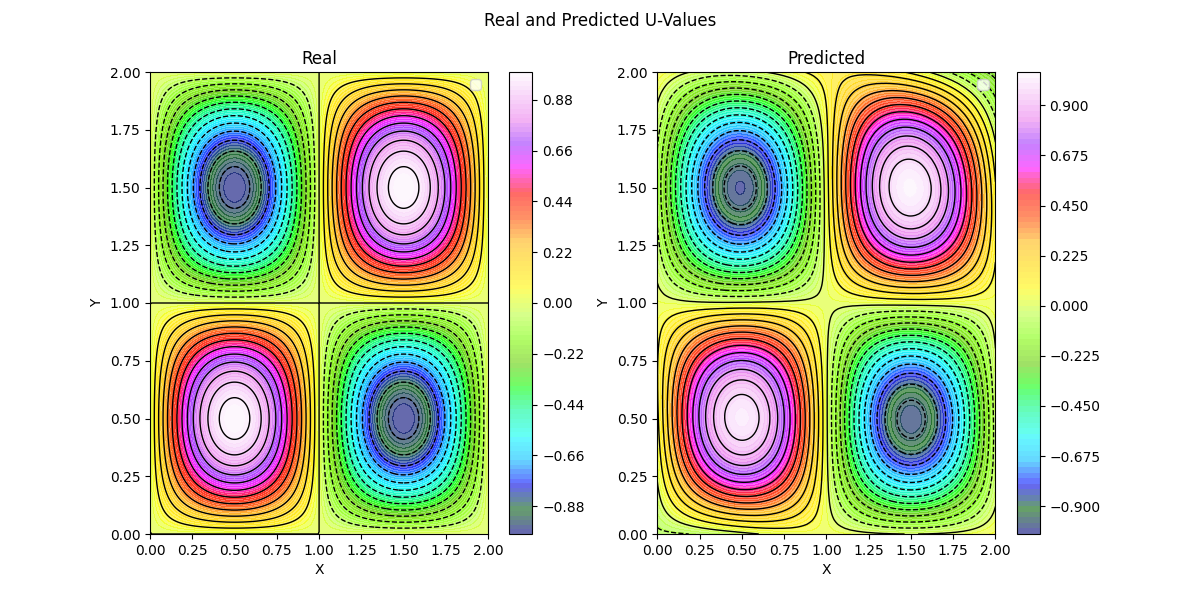

In [51]:
%matplotlib widget
plotter = plotting.NNPlots(test_x, test_y, true_u, x, y, pred_u, x_limits, y_limits)
# plotter.plot3d()
# plotter.plot2d_fix_x(3)

# cool cmaps: coolwarm(set as default), cool, gistncar, rainbow
plotter.plot2d_contour(color_map="gist_ncar", contour_levels=30)

# Accuracy calculation

In [54]:
from accuracy import AccuracyCalc

# 0 koef has bad accuracy)
for i in range(3):
    model.load_weights(checkpoint_path(i))
    calc = AccuracyCalc(model, real_u, area=np.array(pred_coord))
    print("Error:", calc.mse())
    print("Error:", calc.maxe())

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Error: 0.2541878498873083
Error: 2.0230770111083984
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Error: 0.0037486515972020777
Error: 0.3603581488132477
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Error: 0.0013656565936330158
Error: 0.269945353269577
